# Gomb - Net
### Performance test on the WSSe dataset
### And analysis of WSSe experimental data

Austin Houston

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/ahoust17/Gomb-Net/blob/main/Eval_WSSe_model.ipynb)

### Necessary installs

In [2]:
# basics
import os
import sys
import numpy as np

# plotting
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib import cm

# colab interactive plots and drive
drive = False
if 'google.colab' in sys.modules:
    from  google.colab import drive 
    from google.colab import output
    drive.mount('/content/drive')
    output.enable_custom_widget_manager()
    drive = True
else:
    %matplotlib widget

# other imports
import scipy.ndimage as ndimage
from scipy.ndimage import label, center_of_mass, gaussian_filter, zoom
from scipy.spatial import KDTree
from scipy.interpolate import griddata
from scipy.stats import norm, gaussian_kde
from skimage.filters import threshold_otsu
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# for cropping function
print('installing DataGenSTEM')
!pip install ase
!git clone https://github.com/ahoust17/DataGenSTEM.git
sys.path.append('./DataGenSTEM/DataGenSTEM')
import data_generator as dg

# for Gomb-Net
print('installing Gomb-Net')
!git clone https://github.com/ahoust17/Gomb-Net.git
sys.path.append('./Gomb-Net/GombNet')
from networks import *
from loss_func import GombinatorialLoss
from utils import *

import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

installing DataGenSTEM
Cloning into 'DataGenSTEM'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 92 (delta 38), reused 79 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 26.30 MiB | 9.87 MiB/s, done.
Resolving deltas: 100% (38/38), done.
installing Gomb-Net
Cloning into 'Gomb-Net'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 67 (delta 10), reused 14 (delta 6), pack-reused 48 (from 1)
Receiving objects: 100% (67/67), 78.28 MiB | 5.92 MiB/s, done.
Resolving deltas: 100% (23/23), done.
CUDA is not available. Using CPU.


### Now, you need to add the following shared drive to your google drive:
*** WARNING: it is a big file.  Check before you download ***


https://drive.google.com/drive/folders/1tDF283xry5op3t594oBUlcNLKbjRTV7C?usp=sharing

### Run the following cell after the download is complete

In [3]:
if drive:
    shared_folder = 'drive/My Drive/Gomb-Net files'
else:
    shared_folder = '/Users/austin/Desktop/Gomb-Net aux files'

print('available files & directories:')
!ls '{shared_folder}'

available files & directories:
Experimental_datasets Pretrained_models
Graphene_dataset      WSSe_dataset


### Now we can start with the actual code

let's look at the dataset:

In [4]:
# Create dataloaders
images_dir = str(shared_folder + '/WSSe_dataset/images')
labels_dir = str(shared_folder + '/WSSe_dataset/labels')
train_loader, val_loader, test_loader = get_dataloaders(images_dir, labels_dir, batch_size = 1, val_split=0.2, test_split=0.1) 


Train size: 1400, Validation size: 400, Test size: 200


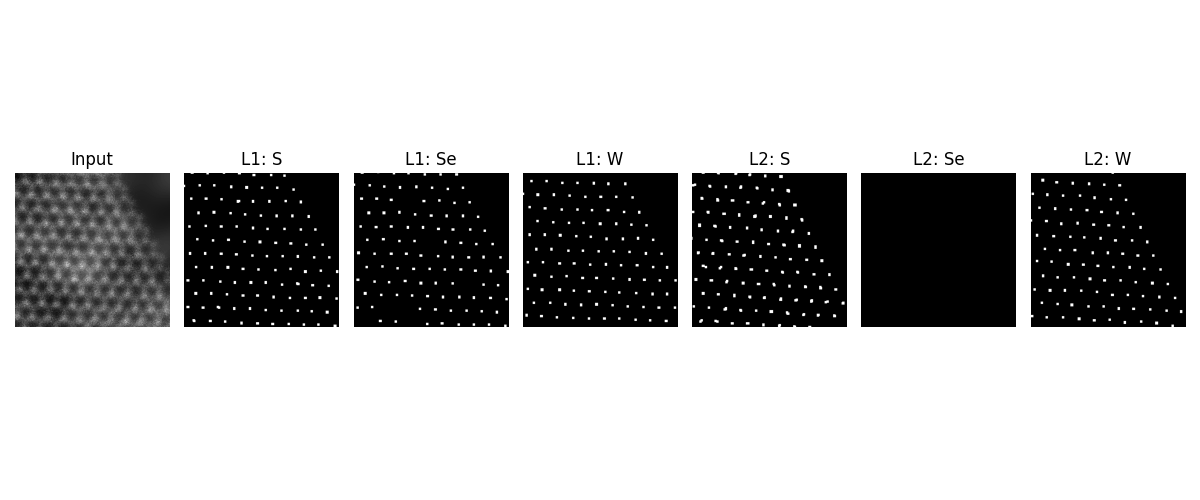

In [11]:
test_iter = 0
test = test_loader.dataset[test_iter][0].unsqueeze(0)
gt = test_loader.dataset[test_iter][1]

fig, ax = plt.subplots(1, 7, figsize=(12, 5))
ax[0].imshow(test[0, 0].cpu().numpy(), cmap='gray')
ax[0].set_title('Input')

titles = ['L1: S', 'L1: Se', 'L1: W', 'L2: S', 'L2: Se', 'L2: W']
for i in range(6):
    ax[i+1].imshow(gt[i].cpu().numpy(), cmap='gray')
    ax[i+1].set_title(titles[i])
for a in ax:
    a.axis('off')
fig.tight_layout()

now let's look at the model:

In [12]:
# Initialize model 'skeleton'
input_channels = 1
num_classes = 6    # number of output classes
num_filters = [64, 128, 256, 512, 1024]

model = TwoLeggedUnet(input_channels, num_classes, num_filters, dropout = 0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = GombinatorialLoss(group_size = num_classes//2, loss = 'Dice', epsilon=1e-6, class_weights = None, alpha=2)

In [13]:
# Get the number of trainable parameters
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_trainable_params = count_trainable_parameters(model)
print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 43235014


visualize the training history for the pretrained model:

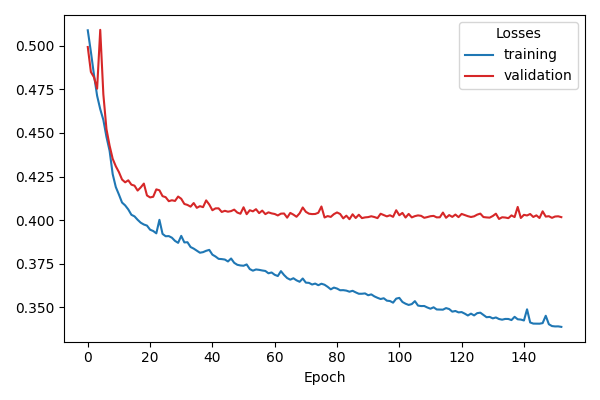

In [15]:
loss_history = np.load(str(shared_folder + '/Pretrained_models/WSSe_model_loss_history.npz'))
train_loss = loss_history['train_loss_history']
val_loss = loss_history['val_loss_history']

plt.figure(figsize = (6,4))
plt.plot(train_loss, label='training', color = '#1f77b4')
plt.plot(val_loss, label='validation', color = '#d62728')
plt.xlabel('Epoch')
plt.legend(title='Losses')
plt.tight_layout()  


load in the pretrained weights onto our model 'skeleton'

In [16]:
model_path = str(shared_folder + '/Pretrained_models/WSSe_model.pth')

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

TwoLeggedUnet(
  (encoders): ModuleDict(
    (encoder_0): EncoderBlock(
      (conv_block): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (encoder_1): EncoderBlock(
      (conv_block): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, ker

visualize some predictions on the test set

In [ ]:
def extract_intensity(image, atoms, radius=5, zoom_factor=2, norm_size=None):
    def circular_mask(radius):
        y, x = np.ogrid[-radius: radius+1, -radius: radius+1]
        mask = x**2 + y**2 <= radius**2
        return mask

    # Pad the image to handle edge cases
    padded_image = np.pad(image, radius, mode='constant', constant_values=0)
    zoomed_image = zoom(padded_image, zoom_factor, order=3)
    zoomed_atoms = [(x * zoom_factor + radius * zoom_factor, y * zoom_factor + radius * zoom_factor) for x, y in atoms]

    num_atoms = len(atoms)
    circular_mask_region = circular_mask(radius)
    intensities = []

    for idx, atom in enumerate(zoomed_atoms):
        x, y = atom
        x, y = int(x), int(y)
        intensity_region = zoomed_image[y - radius:y + radius + 1, x - radius:x + radius + 1]

        if norm_size is not None:
            norm_region = zoomed_image[y - norm_size:y + norm_size + 1, x - norm_size:x + norm_size + 1]
            norm_factor = (norm_region.sum() - intensity_region[circular_mask_region].sum()) / np.sum(~circular_mask_region)
            normalized_intensity = intensity_region[circular_mask_region] / norm_factor
            intensities.append(normalized_intensity)
        else:
            intensities.append(intensity_region[circular_mask_region])
    
    return intensities

In [127]:


def get_atom_positions(image, threshold=0.5, min_distance=5, radius=5, zoom_factor=2):
    centroids = {'W': [], 'S': [], 'Se': []}
    intensities = {'W': [], 'S': [], 'Se': []}
    summed_prob = {'W': [], 'S': [], 'Se': []}

    for i, channel in enumerate(masks):
        if j == 0 or j == 3:
            element = 'S'
        elif j == 1 or j == 4:
            element = 'Se'
        else:
            element = 'W'

        labeled_array, num_features = ndimage.label(layer)
        layer_centroids = np.array(center_of_mass(layer, labeled_array, range(1, num_features + 1)))
        centroids[element].append(layer_centroids)



def handle_outputs(outputs, mode = 'threshold', stdvs_n = 2):
    # possible modes: 'threshold', 'otsu_method', 'prob_area', 'interlayer_prob_area'
    # inputs should be the raw model outputs (for one image)
    prediction = []

    if mode == 'threshold':
        outputs_array = np.array(outputs)
        means = np.mean(outputs_array, axis=(1, 2))
        stdvs = np.std(outputs_array, axis=(1, 2))
        threshold = means + stdvs_n * stdvs
        for channel in range(len(threshold)):
            prediction.append((outputs[channel] > threshold[channel]).float())
    
    elif mode == 'otsu_method':
        for channel in range(outputs.shape[0]):
            prediction.append((outputs[channel] > threshold_otsu(outputs[channel].cpu().numpy())).float())

    elif mode == 'prob_area':
        
        pass
    elif mode == 'interlayer_prob_area':
        pass
    
    return torch.stack(prediction)

In [ ]:
def predict_atoms(image, model, n_classes = 6, output_handling = 'threshold'):
    # Normalize the image
    image = image - np.min(image)
    image = image / np.max(image)

    # Generate the prediction
    image = torch.tensor(image).float().unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        probability = model(image)
        prediction = torch.sigmoid(probability)
    probability = probability.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    # Handle the output
    threshold = [0, -11, 0, 0, 0, 0] # might not actually be used below
    prediction = handle_outputs(probability, mode = output_handling, threshold = threshold)
    
    # Get atom positions
    for channel in range(n_classes):
        prediction[channel] = prediction[channel].astype(np.uint8)
        positions = get_atom_positions(prediction, probability, n_classes)


    # Create a dictionary to store the results
    results = {
        "image": im,
        "mask": masks,
        "probability": probability,
        "centroids": centroids,
        "intensities": intensities
    }

    return results

def refine_atoms(results_dict, ):

    # proccess atom likelihoods
    pass

In [143]:
test_iter = 4
test = test_loader.dataset[test_iter][0].unsqueeze(0)
gt = test_loader.dataset[test_iter][1]

with torch.no_grad():
    outputs = model(test).squeeze(0)
    
prediction = handle_outputs(outputs, mode = 'otsu_method', stdvs_n=3)


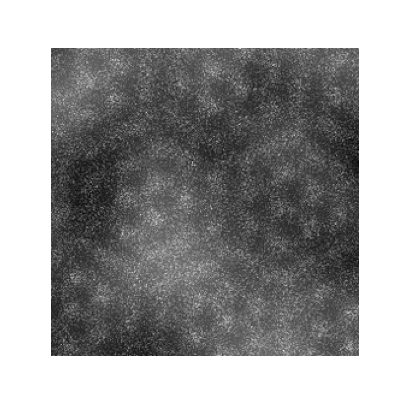

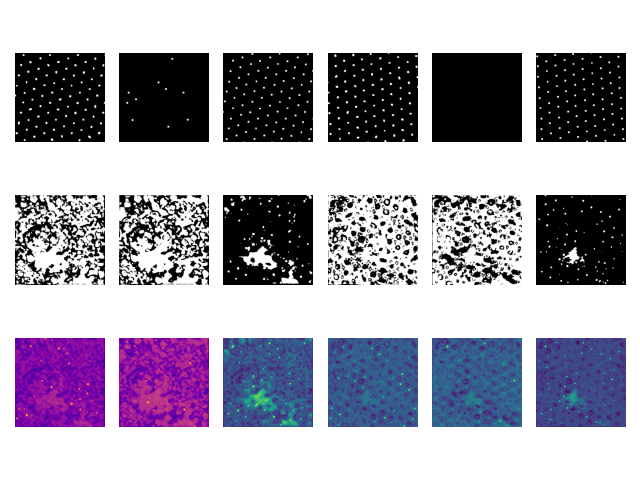

In [144]:

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.imshow(test.squeeze().cpu().numpy(), cmap='gray')
ax.axis('off')

fig, axs = plt.subplots(3,num_classes, sharex=True, sharey=True)

for i in range(num_classes):
    axs[0,i].imshow(gt[i], cmap='gray')
for i in range(num_classes):
    axs[1,i].imshow(prediction[i], cmap='gray')
for i in range(num_classes)[:2]:
    axs[2,i].imshow(outputs[i], cmap='plasma')
for i in range(num_classes)[2:]:
    axs[2,i].imshow(outputs[i], cmap='viridis')
for ax in axs.ravel():
    ax.axis('off')

axs[0,0].set_ylabel('GrounTruth')
axs[1,0].set_ylabel('Prediction')
axs[2,0].set_ylabel('Probability')

fig.tight_layout()

In [70]:
from scipy.ndimage import uniform_filter

def relative_probability(array, kernel_size):
    # Local mean calculation using uniform filter
    local_mean = uniform_filter(array, size=kernel_size)
    
    # Local variance (standard deviation squared)
    local_sqr_mean = uniform_filter(array ** 2, size=kernel_size)
    local_variance = local_sqr_mean - local_mean ** 2
    
    # Calculate local standard deviation
    local_std = np.sqrt(local_variance)
    
    return local_mean, local_std

In [113]:
array = np.array(outputs[1]) 
array = array - np.min(array)
# array = gaussian_filter(array, 1)
x = np.arange(array.shape[1])
y = np.arange(array.shape[0])
x, y = np.meshgrid(x, y)

local_mean, local_std = relative_probability(array, 13)

relative_prob = (array - local_mean) / local_std
relative_prob = gaussian_filter(relative_prob, 1)

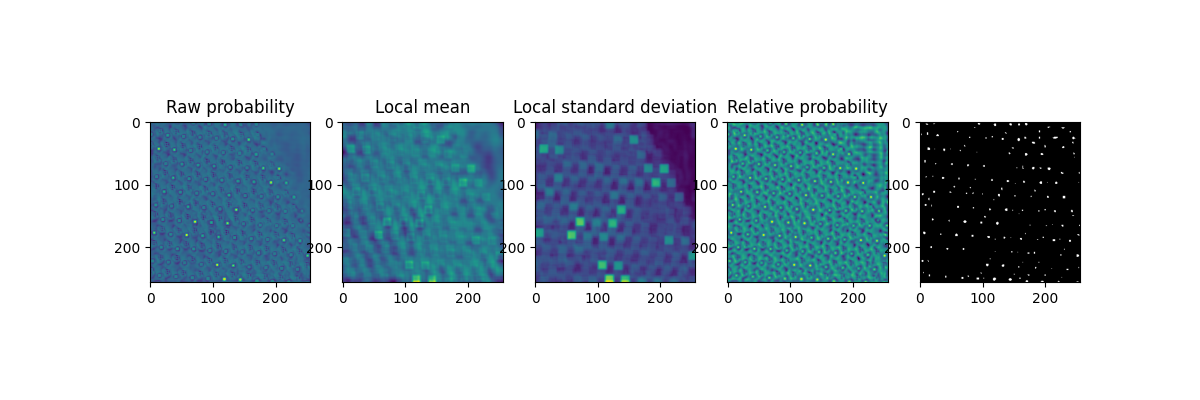

In [117]:
fig, ax = plt.subplots(1, 5, figsize=(12, 4))
ax[0].imshow(array, cmap='viridis')
ax[0].set_title('Raw probability')
ax[1].imshow(local_mean, cmap='viridis')
ax[1].set_title('Local mean')
ax[2].imshow(local_std, cmap='viridis')
ax[2].set_title('Local standard deviation')
ax[3].imshow(relative_prob, cmap='viridis')
ax[3].set_title('Relative probability')

threshold = 1.1
ax[4].imshow(relative_prob > threshold, cmap='gray')


(array([5.90569346e-04, 2.95284673e-04, 2.06698317e-03, 2.65756206e-03,
        2.95284673e-03, 3.54341607e-03, 5.01982786e-03, 7.38209979e-03,
        7.08683215e-03, 1.38783476e-02, 1.68312264e-02, 1.97840274e-02,
        2.42133432e-02, 3.18907447e-02, 3.24812391e-02, 4.04540002e-02,
        4.87218586e-02, 6.34862047e-02, 7.44115659e-02, 7.02777521e-02,
        9.47861613e-02, 1.03644920e-01, 1.28153252e-01, 1.53843315e-01,
        1.67426023e-01, 1.82781213e-01, 1.90163110e-01, 2.26187799e-01,
        2.39180309e-01, 2.71956870e-01, 2.84358812e-01, 3.20088585e-01,
        3.23926913e-01, 3.41348688e-01, 3.83279063e-01, 3.85936622e-01,
        4.00700839e-01, 4.25504723e-01, 4.39383086e-01, 4.60052990e-01,
        4.71273930e-01, 5.05822061e-01, 5.22653419e-01, 5.17928719e-01,
        5.72556403e-01, 5.75509247e-01, 6.39290625e-01, 6.15963117e-01,
        6.44605883e-01, 6.56417071e-01, 7.03367279e-01, 7.24332467e-01,
        6.98347446e-01, 7.06615815e-01, 7.25513186e-01, 6.965757

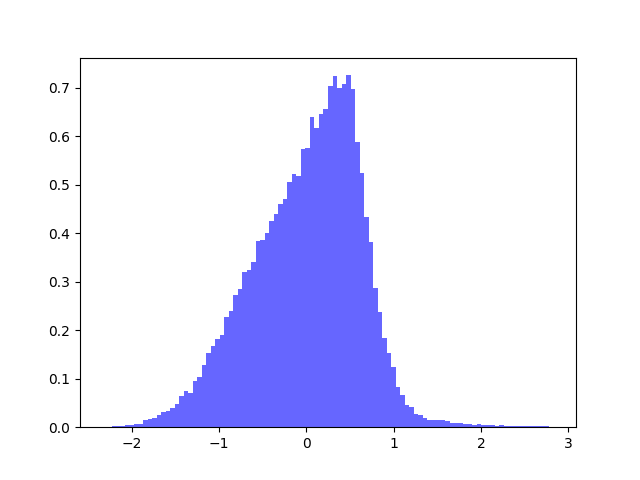

In [116]:
plt.figure()
plt.hist(relative_prob.flatten(), bins=100, density=True, alpha=0.6, color='b')

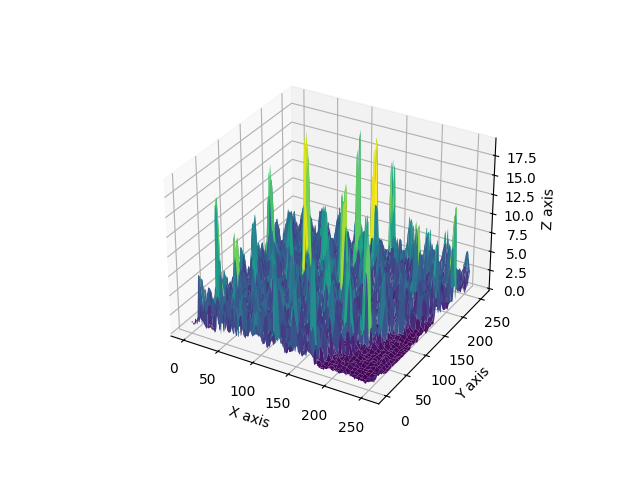

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.plot_surface(x, y, local_std, cmap='viridis')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()

In [ ]:
test_iter = 0
test = test_loader.dataset[test_iter][0].unsqueeze(0)
gt = test_loader.dataset[test_iter][1]

# Generate prediction
with torch.no_grad():
    probability = model(test)
    prediction = torch.sigmoid(probability)
probability = probability.squeeze().cpu().numpy() 
prediction = prediction.squeeze().cpu().numpy()




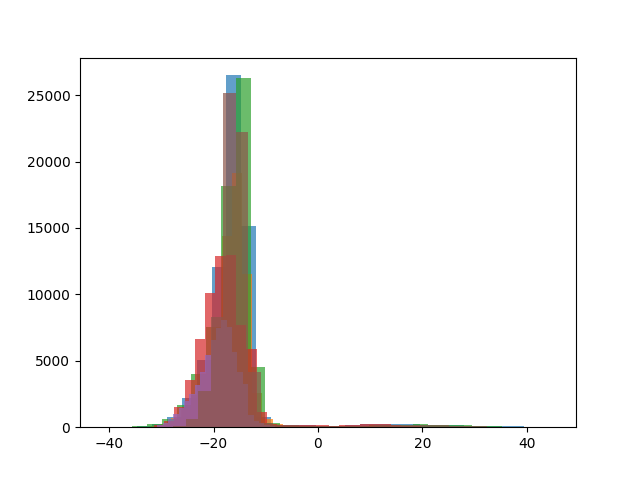

In [33]:
plt.figure()
for channel in range(num_classes):
    plt.hist(probability[channel].flatten(), bins=30, alpha=0.7, label='Probability')

## Now, on Experimental data:

### First, some useful functions:

In [ ]:



def plot_atom_histograms(results, n_bins=50):
    colors = {'W': ['blue', 'cyan'], 'Se': ['green', 'lime'], 'S': ['red', 'magenta']}
    
    for i, result in results.items():
        intensities = {el: [np.concatenate(result['intensities'][el][0]) if result['intensities'][el][0] else np.array([]),
                            np.concatenate(result['intensities'][el][1]) if result['intensities'][el][1] else np.array([])]
                       for el in colors}

        fig, axs = plt.subplots(1, 3, figsize=(20, 8))
        # Plot the image with centroids
        axs[0].imshow(result['image'], cmap='gray')
        for element, colors_list in colors.items():
            for idx, (color, layer) in enumerate(zip(colors_list, result['centroids'][element])):
                if layer.size > 0:
                    axs[0].scatter(layer[:, 1], layer[:, 0], color=color, label=f'{element} Layer {idx + 1} Centroids', alpha=0.6)
        axs[0].axis('off')
        axs[0].legend(loc='upper right', fontsize=8)

        # Plot histograms and KDEs for both layers
        for j, layer in enumerate(['Layer 1', 'Layer 2']):
            for element, (color1, color2) in colors.items():
                color = color1 if j == 0 else color2
                layer_intensities = intensities[element][j]
                if layer_intensities.size > 0:
                    density = gaussian_kde(layer_intensities.flatten())
                    x = np.linspace(min(layer_intensities.flatten()), max(layer_intensities.flatten()), 1000)
                    axs[j + 1].hist(layer_intensities.flatten(), bins=n_bins, color=color, alpha=0.5, label=f'{element} {layer} Intensities', density=False)
                    axs[j + 1].plot(x, density(x), color=color)
            axs[j + 1].set_title(f'{layer} Intensities')
            axs[j + 1].set_xlabel('Intensity')
            axs[j + 1].set_ylabel('Density')
            axs[j + 1].legend(loc='upper right', fontsize=8)

        plt.tight_layout()
        plt.show()


In [ ]:
def plot_vegards_law(results):
    S_atoms = []
    Se_atoms = []
    W_atoms = []

    for result in results:
        for element in results[result]["centroids"]:
            for layer in results[result]["centroids"][element]:
                if element == "S":
                    S_atoms.append(layer)
                elif element == "Se":
                    Se_atoms.append(layer)
                else:
                    W_atoms.append(layer)

    WS2_lattice = 3.15 # Angstrom, https://www.hqgraphene.com/WS2.php
    WSe2_lattice = 3.28 # Angstrom, https://www.hqgraphene.com/WSe2.php
    WSSe_lattice = 3.24 # Angstrom

    # Vegard's law
    def vegards_law(a1, a2, x1, x2):
        return x1*a1 + x2*a2

    x_Se = np.linspace(0,1,11)/2
    ideal_lattice = vegards_law(WS2_lattice, WSSe_lattice, 1-x_Se, x_Se)

    # plot the ideal lattice
    plt.figure(figsize=(6,4))
    plt.plot(x_Se, ideal_lattice, 'k--', label='Vegard\'s Law')

    i = 0
    j = 0
    for S, Se, W in zip(S_atoms, Se_atoms, W_atoms):
        # calculate stoichiometry:
        n_S = len(S)
        n_Se = len(Se)
        
        x_Se = n_Se / (n_S * (2 + n_Se/n_S))

        # calculate the standard error of the mean
        std_err_stoic = np.sqrt((x_Se * (1 - x_Se)) / (n_S + n_Se))

        tree = KDTree(W)
        distances, indices = tree.query(W, k=3)

        # The first column of distances is zero (distance to itself), we want the next two columns
        nearest_distances = distances[:, 1:4] * pixel_size # angstroms
        # keep distances between 2.5 and 4.0
        nearest_distances = nearest_distances[(nearest_distances > 2.5) & (nearest_distances < 4.0)]
        avg_distance = np.mean(nearest_distances)
        std_distance = np.std(nearest_distances)
        std_error = std_distance / np.sqrt(len(nearest_distances))

        if x_Se < 0.07:
            color = '#1f77b4'
            label = 'bottom layer'
            plt.errorbar(x_Se, avg_distance, yerr=std_error, xerr=std_err_stoic,capsize=5, c=color, fmt='o', label=label if i == 0 else None)
            i = i + 1
        else:
            color = '#d62728'
            label = 'top layer'
            plt.errorbar(x_Se, avg_distance, yerr=std_error, xerr=std_err_stoic,capsize=5, c=color, fmt='o', label=label if j == 0 else None)
            j = j + 1

    plt.xlabel('x')
    plt.ylabel('Lattice Constant (Angstrom)')
    plt.legend(loc='lower right', fontsize=12)
    plt.xlim(0,0.32)
    plt.tight_layout()


In [ ]:
def fit_gaussian_mixture(metric, n_components):
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(metric.reshape(-1, 1))
    means = gmm.means_.flatten()
    stds = np.sqrt(gmm.covariances_).flatten()
    weights = gmm.weights_
    log_likelihood = gmm.score(metric.reshape(-1, 1)) * len(metric)
    return means, stds, weights, log_likelihood

def plot_histogram_with_gaussian(ax, metric, title, n_components, color_bounds):
    n, bins, patches = ax.hist(metric, bins=20, density=True, edgecolor='k', alpha=1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm_dist = mcolors.Normalize(color_bounds[0], color_bounds[1])
    cmap = cm.get_cmap("viridis")
    for c, p in zip(bin_centers, patches):
        plt.setp(p, 'facecolor', cmap(norm_dist(c)))
    ax.set_yticks([])

    means, stds, weights, log_likelihood = fit_gaussian_mixture(metric, n_components)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 1000)
    # total_pdf = sum(weight * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    #                 for mean, std, weight in zip(means, stds, weights))
    total_pdf = np.zeros_like(x)
    for mean, std, weight in zip(means, stds, weights):
        print('mean:', mean)
        pdf = weight * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
        total_pdf += pdf
        ax.plot(x, pdf, '--', c='k', linewidth=2)

    ax.plot(x, total_pdf, 'k-', linewidth=3, alpha=0.8)
    ax.set_title(title, fontsize=14)
    ax.set_xlim(np.min(metric), np.max(metric))
    return means, stds, weights, x, total_pdf, log_likelihood

'''def plot_moire_relationship(results, image_number=0, n_gauss=[1, 1]):
    def get_layer_data(layer):
        return np.vstack(results[image_number]["centroids"][layer][0]), np.vstack(results[image_number]["centroids"][layer][1])

    Se_0, Se_1 = get_layer_data("Se")
    W_0, W_1 = get_layer_data("W")
    S_0, S_1 = get_layer_data("S")

    if Se_0.shape[0] > Se_1.shape[0]:
        Se_bottom, W_bottom, S_bottom, W_top = Se_0, W_0, S_0, W_1
    else:
        Se_bottom, W_bottom, S_bottom, W_top = Se_1, W_1, S_1, W_0

    top_tree, bottom_tree = KDTree(W_top), KDTree(W_bottom)
    grid_density = 512
    x = np.linspace(0, 512, grid_density)
    y = np.linspace(0, 512, grid_density)
    X, Y = np.meshgrid(x, y)
    points = np.vstack((X.ravel(), Y.ravel())).T
    distances = np.linalg.norm(W_top[top_tree.query(points)[1]] - W_top[top_tree.query(points)[1]], axis=1)
    distances = distances.reshape((grid_density, grid_density)) * pixel_size
    moire_sites = griddata((X.ravel(), Y.ravel()), distances.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(results[image_number]["image"], cmap='gray')
    axs[0].axis('off')

    cmap, norm_dist = plt.get_cmap('viridis'), mcolors.Normalize(vmin=distances.min(), vmax=distances.max())
    img = axs[1].imshow(distances, cmap=cmap, norm=norm_dist, extent=(0, 512, 512, 0))
    axs[1].scatter(Se_bottom[:, 1], Se_bottom[:, 0], s=30, edgecolors='k', c='orange', linewidths=0.5, alpha=1)
    axs[1].axis('off')
    plt.colorbar(img, ax=axs[1], label='Distance $\AA$')

    color_bounds = [distances.min(), distances.max()]
    print('Se-site distribution')
    plot_histogram_with_gaussian(axs[2], moire_sites.ravel(), 'Se Site Distribution', n_gauss[0], color_bounds)
    print('Moiré distance distribution')
    plot_histogram_with_gaussian(axs[3], distances.ravel(), 'Moiré Distance Distribution', n_gauss[1], color_bounds)

    x_common = np.linspace(min(axs[2].get_xlim()[0], axs[3].get_xlim()[0]), max(axs[2].get_xlim()[1], axs[3].get_xlim()[1]), 1000)
    pdf_moire = sum(weight * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_common - mean) / std) ** 2)
                    for mean, std, weight in zip(*fit_gaussian_mixture(moire_sites.ravel(), n_gauss[0])[:3]))
    pdf_distances = sum(weight * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_common - mean) / std) ** 2)
                        for mean, std, weight in zip(*fit_gaussian_mixture(distances.ravel(), n_gauss[1])[:3]))
    axs[4].hlines(0, x_common.min(), x_common.max(), color='k', linestyle='--')
    axs[4].plot(x_common, pdf_moire, 'b-', linewidth=2, label='Se Site Distribution')
    axs[4].plot(x_common, pdf_distances, 'r-', linewidth=2, label='Moiré Distance Distribution')
    axs[4].plot(x_common, pdf_moire - pdf_distances, 'g-', linewidth=2, label='Difference')
    axs[4].legend(loc='upper right')
    axs[4].set_title('Difference', fontsize=14)
    axs[4].set_xlim(0, 6.0)

    fig.tight_layout()
    plt.show()'''


In [ ]:
def plot_histogram(ax, metric, color_bounds):
    n, bins, patches = ax.hist(metric, bins=20, density=True, edgecolor='k', alpha=1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm_dist = mcolors.Normalize(color_bounds[0], color_bounds[1])
    cmap = cm.get_cmap("viridis")
    for c, p in zip(bin_centers, patches):
        plt.setp(p, 'facecolor', cmap(norm_dist(c)))
    ax.set_yticks([])

    ax.set_xlim(np.min(metric), np.max(metric))
    return

def plot_moire_distances(results, image_number=0):
    def get_layer_data(layer):
        return np.vstack(results[image_number]["centroids"][layer][0]), np.vstack(results[image_number]["centroids"][layer][1])

    Se_0, Se_1 = get_layer_data("Se")
    W_0, W_1 = get_layer_data("W")
    S_0, S_1 = get_layer_data("S")

    if Se_0.shape[0] > Se_1.shape[0]:
        Se_bottom, W_bottom, S_bottom, W_top = Se_0, W_0, S_0, W_1
        Se_top, S_top = Se_1, S_1
    else:
        Se_bottom, W_bottom, S_bottom, W_top = Se_1, W_1, S_1, W_0
        Se_top, S_top = Se_0, S_0
    chalc_top = np.vstack((S_top, Se_top))
    chalc_bottom = np.vstack((S_bottom, Se_bottom))
    W_top_tree, W_bottom_tree = KDTree(W_top), KDTree(W_bottom)
    chalc_top_tree, chalc_bottom_tree = KDTree(chalc_top), KDTree(chalc_bottom)


    fig, ax = plt.subplots(2, 5, figsize=(20, 5))
    ax[0,0].imshow(results[image_number]["image"].T, cmap='gray')
    ax[0,0].set_title('Image')

    grid_density = 512
    x = np.linspace(0, 512, grid_density)
    y = np.linspace(0, 512, grid_density)
    X, Y = np.meshgrid(x, y)
    points = np.vstack((X.ravel(), Y.ravel())).T


    distance_arrays = []

    # W_top - W_bottom distances
    distances = np.linalg.norm(W_top[W_top_tree.query(points)[1]] - W_bottom[W_bottom_tree.query(points)[1]], axis=1)
    distances = distances.reshape((grid_density, grid_density)) * pixel_size
    moire_sites = griddata((X.ravel(), Y.ravel()), distances.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')
    ax[0,1].imshow(distances, cmap='viridis', extent=(0, 512, 512, 0))
    ax[0,1].set_title('W-W Distances')
    color_bounds = [distances.min(), distances.max()]
    plot_histogram(ax[1,1], moire_sites.ravel(), color_bounds)
    distance_arrays.append(distances)

    # W_top - Chalc_bottom distances
    distances = np.linalg.norm(W_top[W_top_tree.query(points)[1]] - chalc_bottom[chalc_bottom_tree.query(points)[1]], axis=1)
    distances = distances.reshape((grid_density, grid_density)) * pixel_size
    moire_sites = griddata((X.ravel(), Y.ravel()), distances.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')
    ax[0,2].imshow(distances, cmap='viridis', extent=(0, 512, 512, 0))
    ax[0,2].set_title('W-Chalc Distances')
    color_bounds = [distances.min(), distances.max()]
    plot_histogram(ax[1,2], moire_sites.ravel(), color_bounds)
    distance_arrays.append(distances)

    # Chalc_top - W_bottom distances
    distances = np.linalg.norm(chalc_top[chalc_top_tree.query(points)[1]] - W_bottom[W_bottom_tree.query(points)[1]], axis=1)
    distances = distances.reshape((grid_density, grid_density)) * pixel_size
    moire_sites = griddata((X.ravel(), Y.ravel()), distances.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')
    ax[0,3].imshow(distances, cmap='viridis', extent=(0, 512, 512, 0))
    ax[0,3].set_title('Chalc-W Distances')
    color_bounds = [distances.min(), distances.max()]
    plot_histogram(ax[1,3], moire_sites.ravel(), color_bounds)
    distance_arrays.append(distances)

    # Chalc_top - Chalc_bottom distances
    distances = np.linalg.norm(chalc_top[chalc_top_tree.query(points)[1]] - chalc_bottom[chalc_bottom_tree.query(points)[1]], axis=1)
    distances = distances.reshape((grid_density, grid_density)) * pixel_size
    moire_sites = griddata((X.ravel(), Y.ravel()), distances.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')
    ax[0,4].imshow(distances, cmap='viridis', extent=(0, 512, 512, 0))
    ax[0,4].set_title('Chalc-Chalc Distances')
    color_bounds = [distances.min(), distances.max()]
    plot_histogram(ax[1,4], moire_sites.ravel(), color_bounds)
    distance_arrays.append(distances)

    for a in ax.ravel()[:5]:
        a.axis('off')
    ax[1,0].axis('off')
    fig.tight_layout()
    plt.show()

    return distance_arrays

In [ ]:
def visualize_predictions(image_number, results, n_classes):
    # Plot the original image
    plt.figure(figsize=(10, 10))
    plt.imshow(results[image_number]['image'], cmap='gray')
    plt.axis('off')
    plt.title('Original Image')

    # Create a figure with subplots for masks and probabilities
    fig, axs = plt.subplots(2, n_classes, figsize=(20, 10))

    # Plot the masks
    for j in range(n_classes):
        axs[0, j].imshow(results[image_number]['mask'][j], cmap='gray')
        axs[0, j].axis('off')
        axs[0, j].set_title(f'Mask {j+1}')

    # Plot the probabilities
    for j in range(n_classes):
        axs[1, j].imshow(results[image_number]['probability'][j], cmap='plasma')
        axs[1, j].axis('off')
        axs[1, j].set_title(f'Probability {j+1}')

    plt.suptitle(f'Results for Image {image_number}', fontsize=16)
    plt.tight_layout()
    plt.show()

### Image 1 ~ 20 deg twist (or -40, however you want to think about it)

In [ ]:
exp_data = exp_data = np.load(str(shared_folder + '/Experimental_datasets/WSSe_haadf.npz'))
im_array = exp_data['im_array']
pixel_size = exp_data['pixel_size']

im_array = np.sum(im_array, axis = 0)

# im_array = gaussian_filter(im_array, sigma=1)
im_array = np.power(im_array,2.6)
im_array = im_array - np.min(im_array)

im_array = im_array / np.max(im_array)


print(f"Pixel size: {pixel_size.astype(float)} m/pix")
plt.figure()
plt.imshow(im_array, cmap='gray')
plt.axis('off')


exp_hist, bins = np.histogram(im_array.ravel(), bins=256, range=(0.0, 1.0))

selected_images = []
for i, data in enumerate(train_loader):
    if i >= 10:
        break
    images = data[0].numpy()  # Convert batch of images to numpy array
    selected_images.append(images)

selected_images = np.concatenate(selected_images, axis=0)
selected_images = selected_images / selected_images.max()
selected_images_raveled = selected_images.ravel()
train_hist, _ = np.histogram(selected_images_raveled, bins=256, range=(0.0, 1.0))

# Plot the histograms
plt.figure()
plt.hist(im_array.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k', alpha=0.5, label='Experimental Image')
plt.plot(bins[:-1], train_hist, 'r', alpha=0.5, label='Training Images')
plt.legend()
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Experimental Image vs Training Images')
plt.show()

n_crops = 10
images = dg.shotgun_crop(im_array, crop_size=512, n_crops = n_crops, roi = None)
# normalize each image in images to 0,1
for i in range(n_crops):
    images[i] = images[i] - np.min(images[i])
    images[i] = images[i] / np.max(images[i])

In [ ]:
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist

In [ ]:
# Define the number of classes and crops
n_classes = 6
n_crops = len(images)
results = {}

# Iterate over the images
for i, im in enumerate(images):
    # Model Prediction
    im_tensor = torch.tensor(im.astype(np.float32)).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        probability = model(im_tensor)
    probability = probability.squeeze().cpu().numpy()
    probability = probability - np.min(probability)
    probability = probability / np.max(probability)
    masks = (probability > 0.5).astype(float)

    centroids = {'W': [], 'S': [], 'Se': []}
    intensities = {'W': [], 'S': [], 'Se': []}
    summed_prob = {'W': [], 'S': [], 'Se': []}

    for j, layer in enumerate(masks):
        if j == 0 or j == 3:
            element = 'S'
        elif j == 1 or j == 4:
            element = 'Se'
        else:
            element = 'W'

        labeled_array, num_features = ndimage.label(layer)
        layer_centroids = np.array(center_of_mass(layer, labeled_array, range(1, num_features + 1)))
        centroids[element].append(layer_centroids)

        layer_intensities = extract_intensity(im, layer_centroids, radius=7, zoom_factor=2, norm_size=None)
        intensities[element].append(layer_intensities)

        # Summing probabilities
        layer_summed_prob = [np.sum(probability[j][tuple(np.round(c).astype(int))]) for c in layer_centroids]
        summed_prob[element].append(layer_summed_prob)

    # Process each group of layers separately
    for k in range(2):
        # Select the appropriate layers
        layers = [(k*3), (k*3)+1, (k*3)+2]
        # Flatten lists for easier manipulation
        centroids_S = np.array(centroids['S'][k])
        centroids_Se = np.array(centroids['Se'][k])
        summed_prob_S = np.array(summed_prob['S'][k])
        summed_prob_Se = np.array(summed_prob['Se'][k])

        # Count W and S+Se atoms within this group
        n_W = len(centroids['W'][k])
        n_S_Se = len(centroids_S) + len(centroids_Se)
        excess_atoms = n_S_Se - n_W

        if excess_atoms > 0:
            # Check for proximity and delete close ones first
            distances = cdist(centroids_S, centroids_Se)
            close_pairs = np.argwhere(distances < 0.001)  # Adjust the threshold distance as needed

            S_mask = np.ones(len(centroids_S), dtype=bool)
            Se_mask = np.ones(len(centroids_Se), dtype=bool)

            for (idx_S, idx_Se) in close_pairs:
                if excess_atoms <= 0:
                    break
                if not S_mask[idx_S] or not Se_mask[idx_Se]:
                    continue
                if summed_prob_S[idx_S] < summed_prob_Se[idx_Se]:
                    S_mask[idx_S] = False
                else:
                    Se_mask[idx_Se] = False
                excess_atoms -= 1

            # If there are still atoms to delete, sort by summed_prob and delete the lowest ones
            if excess_atoms > 0:
                all_probs = np.concatenate((summed_prob_S[S_mask], summed_prob_Se[Se_mask]))
                all_centroids = np.concatenate((centroids_S[S_mask], centroids_Se[Se_mask]), axis=0)
                sorted_indices = np.argsort(all_probs)

                deletion_mask = np.ones(len(all_centroids), dtype=bool)
                for idx in sorted_indices:
                    if excess_atoms <= 0:
                        break
                    deletion_mask[idx] = False
                    excess_atoms -= 1

                # Update centroids after deletion
                valid_indices_S = deletion_mask[:len(centroids_S[S_mask])]
                valid_indices_Se = deletion_mask[len(centroids_S[S_mask]):]

                centroids_S = centroids_S[S_mask][valid_indices_S]
                centroids_Se = centroids_Se[Se_mask][valid_indices_Se]

            # Update intensities after deletion
            intensities['S'][k] = extract_intensity(im, centroids_S, radius=7, zoom_factor=2, norm_size=None)
            intensities['Se'][k] = extract_intensity(im, centroids_Se, radius=7, zoom_factor=2, norm_size=None)
            centroids['S'][k] = centroids_S
            centroids['Se'][k] = centroids_Se

    results[i] = {
        "image": im,
        "mask": masks,
        "probability": probability,
        "centroids": centroids,
        "intensities": intensities
    }

In [ ]:
image_number = 0  # Replace with the desired image number
visualize_predictions(image_number, results, 6)

In [ ]:
plot_vegards_law(results)

In [ ]:
plot_atom_histograms(results)

In [ ]:
def plot_histogram(ax, metric, color_bounds):
    n, bins, patches = ax.hist(metric, bins=20, density=True, edgecolor='k', alpha=1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm_dist = mcolors.Normalize(color_bounds[0], color_bounds[1])
    cmap = cm.get_cmap("inferno")
    for c, p in zip(bin_centers, patches):
        plt.setp(p, 'facecolor', cmap(norm_dist(c)))
    ax.set_yticks([])

    ax.set_xlim(np.min(metric), np.max(metric))
    return

def plot_moire_distances(results, image_number=0):
    def get_layer_data(layer):
        return np.vstack(results[image_number]["centroids"][layer][0]), np.vstack(results[image_number]["centroids"][layer][1])

    Se_0, Se_1 = get_layer_data("Se")
    W_0, W_1 = get_layer_data("W")
    S_0, S_1 = get_layer_data("S")

    if Se_0.shape[0] > Se_1.shape[0]:
        Se_bottom, W_bottom, S_bottom, W_top = Se_0, W_0, S_0, W_1
        Se_top, S_top = Se_1, S_1
    else:
        Se_bottom, W_bottom, S_bottom, W_top = Se_1, W_1, S_1, W_0
        Se_top, S_top = Se_0, S_0
    chalc_top = np.vstack((S_top, Se_top))
    chalc_bottom = np.vstack((S_bottom, Se_bottom))
    W_top_tree, W_bottom_tree = KDTree(W_top), KDTree(W_bottom)
    chalc_top_tree, chalc_bottom_tree = KDTree(chalc_top), KDTree(chalc_bottom)


    fig, ax = plt.subplots(1, 5, figsize=(20, 5), dpi=300)
    ax[0].imshow(results[image_number]["image"], cmap='gray')
    ax[0].set_title('Image')

    grid_density = 512
    x = np.linspace(0, 512, grid_density)
    y = np.linspace(0, 512, grid_density)
    X, Y = np.meshgrid(x, y)
    points = np.vstack((X.ravel(), Y.ravel())).T


    distance_arrays = []

    # W_top - W_bottom distances
    distances = np.linalg.norm(W_top[W_top_tree.query(points)[1]].reshape(-1,2) - W_bottom[W_bottom_tree.query(points)[1]].reshape(-1,2), axis=1)
    distances = distances.reshape((grid_density, grid_density)) * pixel_size
    moire_sites = griddata((X.ravel(), Y.ravel()), distances.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')
    ax[1].imshow(distances, cmap='inferno', extent=(0, 512, 512, 0), vmin=0, vmax=6)
    ax[1].set_title('W-W Distances')
    color_bounds = [distances.min(), distances.max()]
    distance_arrays.append(distances)

    # W_top - Chalc_bottom distances
    distances = np.linalg.norm(W_top[W_top_tree.query(points)[1]].reshape(-1,2) - chalc_bottom[chalc_bottom_tree.query(points)[1]].reshape(-1,2), axis=1)
    distances = distances.reshape((grid_density, grid_density)) * pixel_size
    moire_sites = griddata((X.ravel(), Y.ravel()), distances.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')
    ax[2].imshow(distances, cmap='inferno', extent=(0, 512, 512, 0), vmin=0, vmax=6)
    ax[2].set_title('W-Chalc Distances')
    color_bounds = [distances.min(), distances.max()]
    distance_arrays.append(distances)

    # Chalc_top - W_bottom distances
    distances = np.linalg.norm(chalc_top[chalc_top_tree.query(points)[1]].reshape(-1,2) - W_bottom[W_bottom_tree.query(points)[1]].reshape(-1,2), axis=1)
    distances = distances.reshape((grid_density, grid_density)) * pixel_size
    moire_sites = griddata((X.ravel(), Y.ravel()), distances.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')
    ax[3].imshow(distances, cmap='inferno', extent=(0, 512, 512, 0), vmin=0, vmax=6)
    ax[3].set_title('Chalc-W Distances')
    color_bounds = [distances.min(), distances.max()]
    distance_arrays.append(distances)

    # Chalc_top - Chalc_bottom distances
    distances = np.linalg.norm(chalc_top[chalc_top_tree.query(points)[1]].reshape(-1,2) - chalc_bottom[chalc_bottom_tree.query(points)[1]].reshape(-1,2), axis=1)
    distances = distances.reshape((grid_density, grid_density)) * pixel_size
    moire_sites = griddata((X.ravel(), Y.ravel()), distances.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')
    ax[4].imshow(distances, cmap='inferno', extent=(0, 512, 512, 0), vmin=0, vmax=6)
    ax[4].set_title('Chalc-Chalc Distances')
    color_bounds = [distances.min(), distances.max()]
    distance_arrays.append(distances)

    for a in ax.ravel():
        a.axis('off')
    fig.tight_layout()
    plt.show()

    return distance_arrays

In [ ]:
distance_list = plot_moire_distances(results, image_number=0)

distance_arrays = np.array(distance_list)
# normalize, keep norm factor
norm_shift = distance_arrays.min()
distance_arrays = distance_arrays - distance_arrays.min()
norm_factor = distance_arrays.max()
distance_arrays = distance_arrays / distance_arrays.max()
# slices to include in the array:
distance_arrays = distance_arrays[[0,1,2,3]]

In [ ]:
plt.figure()
plt.imshow(results[0]["image"], cmap='gray', extent=(0, 512, 512, 0)*pixel_size)

In [ ]:
# below,the lowest values (near zero) correspond to 2H stacking

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.neighbors import KDTree
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
from matplotlib.cm import plasma
from matplotlib.cm import jet
from matplotlib.cm import inferno


In [ ]:
image_number=0
def get_layer_data(layer):
    return np.vstack(results[image_number]["centroids"][layer][0]), np.vstack(results[image_number]["centroids"][layer][1])

Se_0, Se_1 = get_layer_data("Se")
W_0, W_1 = get_layer_data("W")
S_0, S_1 = get_layer_data("S")

if Se_0.shape[0] > Se_1.shape[0]:
    Se_bottom, W_bottom, S_bottom, W_top = Se_0, W_0, S_0, W_1
else:
    Se_bottom, W_bottom, S_bottom, W_top = Se_1, W_1, S_1, W_0

map_2H = np.sqrt(distance_arrays[1]**2 + distance_arrays[2]**2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# First subplot
im1 = ax1.imshow(map_2H, cmap='viridis')
ax1.scatter(Se_bottom[:, 1], Se_bottom[:, 0], s=20, c='orange', linewidths=0.5, edgecolors='k', label='Se Sites')
fig.colorbar(im1, ax=ax1)
ax1.axis('off')

grid_density = 512
x = np.linspace(0, 512, grid_density)
y = np.linspace(0, 512, grid_density)
X, Y = np.meshgrid(x, y)
points = np.vstack((X.ravel(), Y.ravel())).T
Se_tree = KDTree(Se_bottom)
moire_sites = griddata((X.ravel(), Y.ravel()), map_2H.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')


binedges = np.histogram_bin_edges(np.concatenate([moire_sites.ravel(), map_2H.ravel()]), bins=50)
hist_moire_sites, _ = np.histogram(moire_sites.ravel(), bins=binedges, density=False)
hist_map_2H, _ = np.histogram(map_2H.ravel(), bins=binedges, density=False)

bin_widths = np.diff(binedges)
hist_moire_sites_density = hist_moire_sites / (np.sum(hist_moire_sites) * bin_widths)
hist_map_2H_density = hist_map_2H / (np.sum(hist_map_2H) * bin_widths)

# Create colormap
norm = Normalize(vmin=np.min(map_2H), vmax=np.max(map_2H))
colors = viridis(norm(binedges[:-1]))
ax2.bar(binedges[:-1], hist_map_2H_density, width=bin_widths, color=colors, edgecolor='k', alpha=1, label='map_ravel')
ax2.step(binedges[:-1], hist_moire_sites_density, where='mid', color='#E69F00', linewidth=3, label='Se_site_distribution')

ax2.legend()
ax2.set_xlim(0, 1)
ax2.set_yticks([])

plt.tight_layout()
plt.show()


### Do this in a batch:



In [ ]:
# Function to get centroid data for a given layer
def get_layer_data(results, image_number, layer):
    return (np.vstack(results[image_number]["centroids"][layer][0]), 
            np.vstack(results[image_number]["centroids"][layer][1]))

# Lists to store raw histogram counts for each image
master_atom_histogram = []
master_2H_map_histogram = []
master_distance_maps = []

# List of image numbers to process
image_numbers = [0, 2, 3, 5, 7]

for image_number in image_numbers:
    # get the distance maps
    distance_list = plot_moire_distances(results, image_number=image_number)
    distance_maps = np.array(distance_list)

    # Calculate 2H map-
    map_2H = np.sqrt(distance_maps[1]**2 + distance_maps[2]**2) 

    # Distance Map Histograms
    grid_density = 512
    x = np.linspace(0, 512, grid_density)
    y = np.linspace(0, 512, grid_density)
    X, Y = np.meshgrid(x, y)
    moire_sites = griddata((X.ravel(), Y.ravel()), map_2H.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')
    distance_map_histogram = map_2H.ravel()

    # atom sites
    # Determine bottom and top layers
    Se_0, Se_1 = get_layer_data(results, image_number, "Se")
    W_0, W_1 = get_layer_data(results, image_number, "W")
    S_0, S_1 = get_layer_data(results, image_number, "S")
    if Se_0.shape[0] > Se_1.shape[0]:
        Se_bottom, W_bottom, S_bottom, W_top = Se_0, W_0, S_0, W_1
    else:
        Se_bottom, W_bottom, S_bottom, W_top = Se_1, W_1, S_1, W_0

    atom_site_histogram = moire_sites.ravel()

    # save the results to the master
    master_atom_histogram.append(atom_site_histogram)
    master_2H_map_histogram.append(distance_map_histogram)
    master_distance_maps.append(distance_maps)

#     fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 5), dpi=300)
# 
#     ax[0].imshow(results[image_number]["image"], cmap='gray')
#     ax[0].set_title('Image')
# 
#     ax[1].imshow(map_2H, cmap='viridis', vmin=0, vmax=4)
#     ax[1].scatter(Se_bottom[:, 1], Se_bottom[:, 0], s=20, c='orange', linewidths=0.5, edgecolors='k', label='Se Sites')
#     ax[1].set_title('2H Map')
# 
#     # W-C map
#     ax[2].imshow(distance_maps[1], cmap='viridis', vmin=0, vmax=4)
#     ax[2].set_title('W-C Distances')
# 
#     # C-W map
#     ax[3].imshow(distance_maps[2], cmap='viridis', vmin=0, vmax=4)
#     ax[3].set_title('C-W Distances')
# 
#     for a in ax:
#         a.axis('off')
#     fig.tight_layout()


In [ ]:
# List of image numbers to process
cmap = 'inferno'
image_numbers = [0, 2, 3, 5, 7]

for image_number in [2]:
    # get the distance maps
    distance_list = plot_moire_distances(results, image_number=image_number)
    distance_maps = np.array(distance_list)

    # Calculate 2H map-
    map_2H = np.sqrt(distance_maps[1]**2 + distance_maps[2]**2) 

    # Distance Map Histograms
    grid_density = 512
    x = np.linspace(0, 512, grid_density)
    y = np.linspace(0, 512, grid_density)
    X, Y = np.meshgrid(x, y)
    moire_sites = griddata((X.ravel(), Y.ravel()), map_2H.ravel(), (Se_bottom[:, 1], Se_bottom[:, 0]), method='cubic')
    distance_map_histogram = map_2H.ravel()

    # atom sites
    # Determine bottom and top layers
    Se_0, Se_1 = get_layer_data(results, image_number, "Se")
    W_0, W_1 = get_layer_data(results, image_number, "W")
    S_0, S_1 = get_layer_data(results, image_number, "S")
    if Se_0.shape[0] > Se_1.shape[0]:
        Se_bottom, W_bottom, S_bottom, W_top = Se_0, W_0, S_0, W_1
    else:
        Se_bottom, W_bottom, S_bottom, W_top = Se_1, W_1, S_1, W_0

    atom_site_histogram = moire_sites.ravel()

    # save the results to the master
    master_atom_histogram.append(atom_site_histogram)
    master_2H_map_histogram.append(distance_map_histogram)
    master_distance_maps.append(distance_maps)

In [ ]:
from cmcrameri import cm

In [ ]:
cmap = 'inferno'
# cmap = cm.batlow
scatter_color = plt.get_cmap('tab10')(2)
# scatter_color = 'red'
for i, image_number in enumerate(image_numbers):    
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 5), dpi=300)

    # atom sites
    # Determine bottom and top layers
    Se_0, Se_1 = get_layer_data(results, image_number, "Se")
    W_0, W_1 = get_layer_data(results, image_number, "W")
    S_0, S_1 = get_layer_data(results, image_number, "S")
    if Se_0.shape[0] > Se_1.shape[0]:
        Se_bottom, W_bottom, S_bottom, W_top = Se_0, W_0, S_0, W_1
    else:
        Se_bottom, W_bottom, S_bottom, W_top = Se_1, W_1, S_1, W_0

    ax[0].imshow(results[image_number]["image"], cmap='gray')
    ax[0].set_title('Image')

    ax[1].imshow(master_2H_map_histogram[i].reshape((512,512)).T, cmap=cmap, vmin=0.2, vmax=6)
    ax[1].scatter(Se_bottom[:, 1], Se_bottom[:, 0], s=100, c=scatter_color, linewidths=2, edgecolors='k', label='Se Sites')
    ax[1].set_title('2H Map')

    # W-C map
    ax[2].imshow(master_distance_maps[i][1].T, cmap=cmap, vmin=0, vmax=6)
    ax[2].set_title('W-Chalchogen Distances')

    # C-W map
    ax[3].imshow(master_distance_maps[i][2].T, cmap=cmap, vmin=0, vmax=6)
    ax[3].set_title('Chalcogen-W Distances')

    for a in ax:
        a.axis('off')
    fig.tight_layout()


In [ ]:
# to normalize the x-axis:
lattice_constant = 1
n_bins = 100

# Concatenate all histograms
combined_atom_histogram = np.concatenate(master_atom_histogram)
combined_2H_map_histogram = np.concatenate(master_2H_map_histogram)

# Compute new bin edges
binedges_total = np.histogram_bin_edges(np.concatenate([combined_atom_histogram, combined_2H_map_histogram]), bins=n_bins)
hist_atom_total, _ = np.histogram(combined_atom_histogram, bins=binedges_total, density=True)
hist_2H_map_total, _ = np.histogram(combined_2H_map_histogram, bins=binedges_total, density=True)  
binedges_total = binedges_total / lattice_constant
bin_widths_total = np.diff(binedges_total)
hist_atom_density_total = hist_atom_total / (np.sum(hist_atom_total) * bin_widths_total)
hist_2H_map_density_total = hist_2H_map_total / (np.sum(hist_2H_map_total) * bin_widths_total)

normalized_histogram = hist_atom_density_total / hist_2H_map_density_total

fig, ax = plt.subplots(figsize=(9, 6))#, dpi=300)

norm = Normalize(vmin=np.min(binedges_total), vmax=np.max(binedges_total))
colors_total = inferno(norm(binedges_total[:-1]))
ax.bar(binedges_total[:-1], hist_2H_map_density_total, width=bin_widths_total, color=colors_total, edgecolor='k', alpha=1, label='2H Map Density')
ax.step(binedges_total, np.append(hist_atom_density_total, hist_atom_density_total[-1]), where='post', color=scatter_color, linewidth=3, label='Se Site Density')
ax.plot([binedges_total[0], binedges_total[0]], [0, hist_atom_density_total[0]], color='#E69F00', linewidth=3)
for dist in [0,1,np.sqrt(2)]:
    ax.axvline(x=dist*3.16, ymin=0, ymax=100, color='k', linestyle = '--', linewidth=3)
ax.legend(loc='upper left')
ax.set_xlim(-0.1, 6)


plt.xlabel('Distance (Angstroms)')
plt.tight_layout()


In [ ]:
data = combined_2H_map_histogram

# Calculate the standard deviation and IQR
std_dev = np.std(data)
iqr = np.percentile(data, 75) - np.percentile(data, 25)
n = len(data)

# Calculate the bandwidth using Silverman's rule of thumb
bandwidth = 0.9 * min(std_dev, iqr / 1.34) * n**(-1/5)

print(f"Calculated bandwidth: {bandwidth}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import jet
from sklearn.neighbors import KernelDensity

# Kernel density estimation function
def compute_kde(data, bandwidth=0.1, n_bins=100, x_min=0, x_max=10):
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(data[:, np.newaxis])
    x_d = np.linspace(x_min, x_max, n_bins)
    log_dens = kde.score_samples(x_d[:, np.newaxis])
    return np.exp(log_dens), x_d

# Normalize the x-axis
lattice_constant = 1
n_bins = 100
bandwidth = 0.1

# Concatenate all histograms
combined_atom_histogram = np.concatenate(master_atom_histogram)
combined_2H_map_histogram = np.concatenate(master_2H_map_histogram)

# Apply KDE to both histograms
kde_atom_density_total, x_d = compute_kde(combined_atom_histogram, bandwidth, n_bins)
kde_2H_map_density_total, _ = compute_kde(combined_2H_map_histogram, bandwidth, n_bins)

# Compute bin edges for plotting
binedges_total = x_d / lattice_constant
bin_widths_total = np.diff(binedges_total)

# Plotting
fig, ax = plt.subplots(figsize=(9, 6))

norm = Normalize(vmin=np.min(binedges_total), vmax=np.max(binedges_total))
colors_total = inferno(norm(binedges_total[:-1]))

# KDE plot for 2H Map Density
ax.plot(binedges_total, kde_2H_map_density_total, color='purple', label='2H Map Density')
ax.fill_between(binedges_total, kde_2H_map_density_total, color='purple', alpha=0.3)
ax.plot(binedges_total, kde_atom_density_total, color='green', label='Se Site Density')
ax.fill_between(binedges_total, kde_atom_density_total, color='green', alpha=0.3)
ax.legend(loc='upper left')
ax.set_xlim(-0.1, 6)
ax.set_ylim(0,0.8)
for dist in [0,1,np.sqrt(2)]:
    ax.axvline(x=dist*3.16, ymin=0, ymax=100, color='k', linestyle = '--', linewidth=3)

plt.xlabel('Distance (Angstroms)')
plt.tight_layout()


In [ ]:
from sklearn.neighbors import KernelDensity
from matplotlib.colors import Normalize
from matplotlib.cm import inferno

In [ ]:
# Kernel density estimation function
def compute_kde(data, bandwidth=0.1, n_bins=100, x_min=0, x_max=10):
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(data[:, np.newaxis])
    x_d = np.linspace(x_min, x_max, n_bins)
    log_dens = kde.score_samples(x_d[:, np.newaxis])
    return np.exp(log_dens), x_d

# Bootstrap KDE
def bootstrap_kde(data, n_bootstrap=1000, bandwidth=0.1, n_bins=100, x_min=0, x_max=10):
    kde_samples = np.zeros((n_bootstrap, n_bins))
    for i in range(n_bootstrap):
        resample = np.random.choice(data, size=len(data), replace=True)
        kde_samples[i], x_d = compute_kde(resample, bandwidth, n_bins, x_min, x_max)
    kde_mean = np.mean(kde_samples, axis=0)
    kde_std = np.std(kde_samples, axis=0)
    return kde_mean, kde_std, x_d

# Normalize the x-axis
lattice_constant = 1
n_bins = 100
bandwidth = 0.1

# Concatenate all histograms
combined_atom_histogram = np.concatenate(master_atom_histogram)
combined_2H_map_histogram = np.concatenate(master_2H_map_histogram)

# Apply KDE with bootstrapping to both histograms
kde_atom_mean, kde_atom_std, x_d = bootstrap_kde(combined_atom_histogram, n_bootstrap=10, bandwidth=bandwidth, n_bins=n_bins)
kde_2H_map_mean, kde_2H_map_std, _ = bootstrap_kde(combined_2H_map_histogram, n_bootstrap=10, bandwidth=bandwidth, n_bins=n_bins)

# Compute bin edges for plotting
binedges_total = x_d / lattice_constant
bin_widths_total = np.diff(binedges_total)

# Plotting
fig, ax = plt.subplots(figsize=(9, 6))

norm = Normalize(vmin=np.min(binedges_total), vmax=np.max(binedges_total))
colors_total = inferno(norm(binedges_total[:-1]))

# KDE plot for 2H Map Density with error bands
ax.plot(binedges_total, kde_2H_map_mean, color='purple', label='2H Map Density')
ax.fill_between(binedges_total, kde_2H_map_mean - kde_2H_map_std, kde_2H_map_mean + kde_2H_map_std, color='purple', alpha=0.3)
ax.plot(binedges_total, kde_atom_mean, color='green', label='Se Site Density')
ax.fill_between(binedges_total, kde_atom_mean - kde_atom_std, kde_atom_mean + kde_atom_std, color='green', alpha=0.3)
ax.legend(loc='upper left')
ax.set_xlim(-0.1, 6)
ax.set_ylim(0, 0.8)
for dist in [0, 1, np.sqrt(2)]:
    ax.axvline(x=dist * 3.16, ymin=0, ymax=100, color='k', linestyle='--', linewidth=3)

plt.xlabel('Distance (Angstroms)')
plt.tight_layout()
plt.show()

In [ ]:
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

In [ ]:

# Compute bin edges for plotting
binedges_total = x_d / lattice_constant
bin_widths_total = np.diff(binedges_total)

# Compute histogram for 2H map density
hist_2H_map_density_total, _ = np.histogram(combined_2H_map_histogram, bins=binedges_total, density=True)
hist_2H_map_density_total /= np.sum(hist_2H_map_density_total * bin_widths_total)  # Normalize

# Calculate bin midpoints for bar plot
bin_midpoints = binedges_total[:-1] + bin_widths_total / 2

# Plotting
fig, ax = plt.subplots(figsize=(9, 7))

norm = Normalize(vmin=np.min(binedges_total), vmax=np.max(binedges_total))
colors_total = inferno(norm(binedges_total[:-1]))

# Bar plot for 2H map density
ax.bar(bin_midpoints, hist_2H_map_density_total, width=bin_widths_total, color=colors_total, edgecolor='k', alpha=0.9)

# KDE plot for 2H Map Density with error bands
ax.plot(binedges_total, kde_2H_map_mean, color='black', linewidth=6)  # Black edge
ax.plot(binedges_total, kde_2H_map_mean, color='purple', label='2H distance map', linewidth=4)  # Main line
ax.fill_between(binedges_total, kde_2H_map_mean - kde_2H_map_std, kde_2H_map_mean + kde_2H_map_std, color='purple', alpha=0.4)

ax.plot(binedges_total, kde_atom_mean, color='black', linewidth=6)  # Black edge
ax.plot(binedges_total, kde_atom_mean, color='green', label='Se-site distribution', linewidth=4)
ax.fill_between(binedges_total, kde_atom_mean - kde_atom_std, kde_atom_mean + kde_atom_std, color='green', alpha=0.4)

stackings = [r'2H', r'1T$^\prime$', r'1T']
for dist, stack in zip([0, 1, np.sqrt(2)], stackings):
    ax.axvline(x=dist * 3.16, ymin=0, ymax=100, color='k', linestyle='-', linewidth=3, alpha = 0.8)
    ax.text(dist * 3.16 + 0.1, 0.5, stack+' stacking', fontsize=18, va='bottom', color='k')



cmap = inferno
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Define a custom patch for the legend
legend_patch = mpatches.Patch(color='purple', label='2H distance map')  # Placeholder, not gradient
# Add the custom patch to the legend
ax.legend(handles=[legend_patch, mpatches.Patch(color=cmap(norm(0.5)), label='2H distance map gradient')], loc='upper left')


ax.set_xlabel(f'Distance ($\AA$)')
ax.set_xlim(-0.1, 6)

ax.set_ylabel('Normalized Density (a.u.)')
ax.set_ylim(0, 0.8)
ax.set_yticks([])



fig.tight_layout()

In [ ]:
mse = np.mean((kde_atom_mean - kde_2H_map_mean) ** 2)

print(f'Mean Squared Error (MSE) between the two distributions: {mse}')

In [ ]:

# Compute bin edges for plotting
binedges_total = x_d / lattice_constant
bin_widths_total = np.diff(binedges_total)

# Compute histogram for 2H map density
hist_2H_map_density_total, _ = np.histogram(combined_2H_map_histogram, bins=binedges_total, density=True)
hist_2H_map_density_total /= np.sum(hist_2H_map_density_total * bin_widths_total)  # Normalize

# Calculate bin midpoints for bar plot
bin_midpoints = binedges_total[:-1] + bin_widths_total / 2

# Plotting
fig, ax = plt.subplots(figsize=(11, 6), dpi=300)

norm = Normalize(vmin=np.min(binedges_total), vmax=np.max(binedges_total))
colors_total = inferno(norm(binedges_total[:-1]))

# Bar plot for 2H map density
bar_container = ax.bar(bin_midpoints, hist_2H_map_density_total, width=bin_widths_total, color=colors_total, edgecolor='k', alpha=0.9)

# KDE plot for 2H Map Density with error bands
line1, = ax.plot(binedges_total, kde_2H_map_mean, color='black', linewidth=6)  # Black edge
line2, = ax.plot(binedges_total, kde_2H_map_mean, color='purple', label='2H distance map KDE', linewidth=4)  # Main line
ax.fill_between(binedges_total, kde_2H_map_mean - kde_2H_map_std, kde_2H_map_mean + kde_2H_map_std, color='purple', alpha=0.4)

line3, = ax.plot(binedges_total, kde_atom_mean, color='black', linewidth=6)  # Black edge
line4, = ax.plot(binedges_total, kde_atom_mean, color='green', label='Se-site distribution KDE', linewidth=4)
ax.fill_between(binedges_total, kde_atom_mean - kde_atom_std, kde_atom_mean + kde_atom_std, color='green', alpha=0.4)

stackings = [r'2H', r'1T$^\prime$', r'1T']
delta_d = 0.04
for dist, stack in zip([0, 1, np.sqrt(2)], stackings):
    lattice_fudge = delta_d * np.sqrt(2)
    # fill from dist * 3.16 - lattice_fudge to dist * 3.16 + lattice_fudge
    ax.fill_betweenx([0, 1], dist * 3.16 - lattice_fudge, dist * 3.16 + lattice_fudge, color='k', alpha=0.4)
    ax.axvline(x=dist * 3.16, ymin=0, ymax=100, color='k', linestyle='-', linewidth=3, alpha = 0.8)

# Add the colorbar to represent the gradient
sm = ScalarMappable(cmap=inferno, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical', label='Distance (Angstroms)')

# Define a custom patch for the legend
legend_patch = mpatches.Patch(color='purple', label='2H distance map')

# Update the legend to include all necessary handles
ax.legend(handles=[legend_patch, line2, line4], loc='upper left', bbox_to_anchor=(0.01, 1), fontsize=16)

ax.set_xlabel(f'Distance ($\AA$)')
ax.set_xlim(-0.1, 6)

ax.set_ylabel('Normalized Density (a.u.)')
ax.set_ylim(0, 0.8)
ax.set_yticks([])

fig.tight_layout()
plt.show()